
# Grid Pathfinding Benchmark — Corner‑Paired, Reproducible


In [1]:

import os, sys, time, math, random, platform
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Callable, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import psutil
except Exception:
    psutil=None
ARTIFACTS = os.path.join('.', 'artifacts_all_in_one')
os.makedirs(ARTIFACTS, exist_ok=True)
def manifest():
    return {"platform": platform.platform(),
            "python": sys.version.split()[0],
            "cpu_count": os.cpu_count(),
            "psutil": bool(psutil),
            "numpy": np.__version__,
            "pandas": pd.__version__,
            "matplotlib": plt.matplotlib.__version__}
print("Manifest:", manifest())


Manifest: {'platform': 'Windows-11-10.0.26200-SP0', 'python': '3.12.3', 'cpu_count': 32, 'psutil': True, 'numpy': '1.26.4', 'pandas': '2.2.2', 'matplotlib': '3.8.4'}


In [2]:

def generate_maze_dfs_seeded(width:int, height:int, seed:int=0)->np.ndarray:
    rng=random.Random(seed)
    maze=np.ones((height,width),dtype=int)
    stack=[(1,1)]
    maze[1,1]=0
    dirs=[(-2,0),(2,0),(0,-2),(0,2)]
    while stack:
        y,x=stack.pop()
        rng.shuffle(dirs)
        for dy,dx in dirs:
            ny,nx=y+dy,x+dx
            if 1<=ny<height-1 and 1<=nx<width-1 and maze[ny,nx]==1:
                maze[ny,nx]=0
                maze[y+dy//2,x+dx//2]=0
                stack.append((ny,nx))
    maze[1,1]=0
    maze[height-2,width-2]=0
    return maze
def add_loops(maze:np.ndarray,p:float,seed:int=0)->np.ndarray:
    rng=np.random.default_rng(seed)
    out=maze.copy()
    H,W=out.shape
    for y in range(1,H-1):
        for x in range(1,W-1):
            if out[y,x]==1 and rng.random()<p:
                out[y,x]=0
    return out
def free_cells(maze:np.ndarray)->int:
    return int(np.sum(maze==0))
def hygiene()->None:
    import gc; gc.collect(); time.sleep(0.0)


In [3]:

from heapq import heappush, heappop
def dfs_metrics(maze,start,end):
    H,W=maze.shape
    vis=np.zeros((H,W),dtype=bool)
    vis[start]=True
    stack=[(start[0],start[1],[start])]
    dirs=[(-1,0),(1,0),(0,-1),(0,1)]
    expanded=0; generated=1; peak_frontier=len(stack); peak_closed=0
    expanded_order=[]; pop_times_ns=[]; t0=time.perf_counter_ns()
    while stack:
        y,x,path=stack.pop()
        expanded+=1; peak_closed+=1
        expanded_order.append((y,x)); pop_times_ns.append(time.perf_counter_ns()-t0)
        peak_frontier=max(peak_frontier,len(stack))
        if (y,x)==end:
            return {"path":path,"nodes_expanded":expanded,"nodes_generated":generated,
                    "peak_frontier":peak_frontier,"peak_closed":peak_closed,
                    "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}
        for dy,dx in dirs:
            ny,nx=y+dy,x+dx
            if 0<=ny<H and 0<=nx<W and maze[ny,nx]==0 and not vis[ny,nx]:
                vis[ny,nx]=True; generated+=1
                stack.append((ny,nx,path+[(ny,nx)]))
                peak_frontier=max(peak_frontier,len(stack))
    return {"path":[],"nodes_expanded":expanded,"nodes_generated":generated,
            "peak_frontier":peak_frontier,"peak_closed":peak_closed,
            "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}
def dijkstra_metrics(maze,start,end):
    H,W=maze.shape
    dist=np.full((H,W),np.inf); dist[start]=0.0
    parent={start:None}; pq=[(0.0,start)]
    expanded=0; generated=1; peak_frontier=len(pq); expanded_order=[]; pop_times_ns=[]; closed=set(); t0=time.perf_counter_ns()
    while pq:
        d,cur=heappop(pq)
        if cur in closed: continue
        closed.add(cur); expanded+=1; expanded_order.append(cur); pop_times_ns.append(time.perf_counter_ns()-t0)
        peak_frontier=max(peak_frontier,len(pq))
        if cur==end:
            path=[]; x=cur
            while x is not None: path.append(x); x=parent[x]
            path.reverse()
            return {"path":path,"nodes_expanded":expanded,"nodes_generated":generated,
                    "peak_frontier":peak_frontier,"peak_closed":len(closed),
                    "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}
        cy,cx=cur
        for dy,dx in [(-1,0),(1,0),(0,-1),(0,1)]:
            ny,nx=cy+dy,cx+dx
            if 0<=ny<H and 0<=nx<W and maze[ny,nx]==0:
                cand=d+1.0
                if cand<dist[ny,nx]:
                    dist[ny,nx]=cand; parent[(ny,nx)]=cur; heappush(pq,(cand,(ny,nx))); generated+=1
                    peak_frontier=max(peak_frontier,len(pq))
    return {"path":[],"nodes_expanded":expanded,"nodes_generated":generated,
            "peak_frontier":peak_frontier,"peak_closed":len(closed),
            "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}
def astar_metrics(maze,start,end):
    def h(p): return abs(p[0]-end[0])+abs(p[1]-end[1])
    g={start:0.0}; parent={start:None}; pq=[(h(start),0.0,start)]
    expanded=0; generated=1; peak_frontier=len(pq); expanded_order=[]; pop_times_ns=[]; closed=set()
    while pq:
        f,gc,cur=heappop(pq)
        if cur in closed: continue
        closed.add(cur); expanded+=1; expanded_order.append(cur); pop_times_ns.append(time.perf_counter_ns())
        peak_frontier=max(peak_frontier,len(pq))
        if cur==end:
            path=[]; x=cur
            while x is not None: path.append(x); x=parent[x]
            path.reverse()
            return {"path":path,"nodes_expanded":expanded,"nodes_generated":generated,
                    "peak_frontier":peak_frontier,"peak_closed":len(closed),
                    "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}
        cy,cx=cur
        for dy,dx in [(-1,0),(1,0),(0,-1),(0,1)]:
            ny,nx=cy+dy,cx+dx
            if 0<=ny<maze.shape[0] and 0<=nx<maze.shape[1] and maze[ny,nx]==0:
                cand=gc+1.0
                if cand<g.get((ny,nx),1e18):
                    g[(ny,nx)]=cand; parent[(ny,nx)]=cur; heappush(pq,(cand+h((ny,nx)),cand,(ny,nx))); generated+=1
                    peak_frontier=max(peak_frontier,len(pq))
    return {"path":[],"nodes_expanded":expanded,"nodes_generated":generated,
            "peak_frontier":peak_frontier,"peak_closed":len(closed),
            "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}
def is_valid_position(grid,pos):
    y,x=pos; H,W=grid.shape; return 0<=y<H and 0<=x<W and grid[y,x]==0
def has_forced_neighbors(grid,pos,direction):
    row,col=pos; dr,dc=direction
    if dr!=0 and dc!=0:
        return ((not is_valid_position(grid,(row-dr,col)) and is_valid_position(grid,(row-dr,col+dc))) or
                (not is_valid_position(grid,(row,col-dc)) and is_valid_position(grid,(row+dr,col-dc))))
    elif dc!=0:
        return ((not is_valid_position(grid,(row+1,col)) and is_valid_position(grid,(row+1,col+dc))) or
                (not is_valid_position(grid,(row-1,col)) and is_valid_position(grid,(row-1,col+dc))))
    elif dr!=0:
        return ((not is_valid_position(grid,(row,col+1)) and is_valid_position(grid,(row+dr,col+1))) or
                (not is_valid_position(grid,(row,col-1)) and is_valid_position(grid,(row+dr,col-1))))
    return False
def get_neighbors(grid,pos,parent):
    row,col=pos
    dirs=[(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1),(-1,-1)]
    if parent is None:
        out=[]
        for dr,dc in dirs:
            nr,nc=row+dr,col+dc
            if is_valid_position(grid,(nr,nc)): out.append((dr,dc))
        return out
    pr,pc=parent
    dx=0 if col==pc else (1 if col>pc else -1)
    dy=0 if row==pr else (1 if row>pr else -1)
    out=[]
    if dx!=0 and dy!=0:
        if is_valid_position(grid,(row+dy,col+dx)): out.append((dy,dx))
        if not is_valid_position(grid,(row,col-dx)) and is_valid_position(grid,(row+dy,col)): out.append((dy,0))
        if not is_valid_position(grid,(row-dy,col)) and is_valid_position(grid,(row,col+dx)): out.append((0,dx))
    elif dx!=0:
        if is_valid_position(grid,(row,col+dx)): out.append((0,dx))
        if not is_valid_position(grid,(row+1,col)) and is_valid_position(grid,(row+1,col+dx)): out.append((1,dx))
        if not is_valid_position(grid,(row-1,col)) and is_valid_position(grid,(row-1,col+dx)): out.append((-1,dx))
    elif dy!=0:
        if is_valid_position(grid,(row+dy,col)): out.append((dy,0))
        if not is_valid_position(grid,(row,col+1)) and is_valid_position(grid,(row+dy,col+1)): out.append((dy,1))
        if not is_valid_position(grid,(row,col-1)) and is_valid_position(grid,(row+dy,col-1)): out.append((dy,-1))
    return out
def jump(grid,pos,direction,goal):
    row,col=pos; dr,dc=direction; nr,nc=row+dr,col+dc
    if not is_valid_position(grid,(nr,nc)): return None
    if (nr,nc)==goal: return (nr,nc)
    if has_forced_neighbors(grid,(nr,nc),direction): return (nr,nc)
    if dr!=0 and dc!=0:
        if jump(grid,(nr,nc),(0,dc),goal) is not None: return (nr,nc)
        if jump(grid,(nr,nc),(dr,0),goal) is not None: return (nr,nc)
    return jump(grid,(nr,nc),direction,goal)
def solve_maze_jps(grid,start,goal):
    if not is_valid_position(grid,start) or not is_valid_position(grid,goal): return None, []
    if start==goal: return [start],[1]
    open_set=[(0.0,0.0,start,None)]; closed=set(); came_from={}; g_score={start:0.0}; steps=[]
    def e(a,b): return math.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
    while open_set:
        f,gc,cur,par=heappop(open_set)
        if cur in closed: continue
        closed.add(cur); came_from[cur]=par; steps.append(len(closed))
        if cur==goal:
            path=[]; x=goal
            while x is not None: path.append(x); x=came_from.get(x)
            path.reverse(); return path, steps
        for d in get_neighbors(grid,cur,par):
            jp=jump(grid,cur,d,goal)
            if jp is None or jp in closed: continue
            cand=gc+e(cur,jp)
            if cand<g_score.get(jp,1e18):
                g_score[jp]=cand; heappush(open_set,(cand+e(jp,goal),cand,jp,cur))
    return None, steps
def _astar_4(grid,s,g):
    if s==g: return [s]
    H,W=grid.shape
    def ok(y,x): return 0<=y<H and 0<=x<W and grid[y,x]==0
    def h(p): return abs(p[0]-g[0])+abs(p[1]-g[1])
    openq=[(h(s),0.0,s)]; parent={s:None}; gscore={s:0.0}
    while openq:
        f,gc,cur=heappop(openq)
        if cur==g:
            path=[]; x=cur
            while x is not None: path.append(x); x=parent[x]
            path.reverse(); return path
        cy,cx=cur
        for dy,dx in [(-1,0),(1,0),(0,-1),(0,1)]:
            ny,nx=cy+dy,cx+dx
            if not ok(ny,nx): continue
            cand=gc+1.0
            if cand<gscore.get((ny,nx),1e18):
                gscore[(ny,nx)]=cand; parent[(ny,nx)]=cur; heappush(openq,(cand+h((ny,nx)),cand,(ny,nx)))
    return []
def _stitch_jump_path_to_4(path_jump,grid):
    if not path_jump: return []
    full=[path_jump[0]]
    for a,b in zip(path_jump,path_jump[1:]):
        seg=_astar_4(grid,a,b)
        if not seg: return []
        full.extend(seg[1:])
    out=[full[0]]
    for p in full[1:]:
        if p!=out[-1]: out.append(p)
    return out
def jps_metrics_stitched(maze,start,end):
    jp_path,steps=solve_maze_jps(maze,start,end); jp_path=jp_path or []
    path4=_stitch_jump_path_to_4(jp_path,maze)
    if not path4: path4=_astar_4(maze,start,end)
    expanded=int(steps[-1]) if steps else float('nan')
    return {"path":path4 or [],"nodes_expanded":expanded,"nodes_generated":float('nan'),
            "peak_frontier":float('nan'),"peak_closed":expanded,"expanded_order":[],"pop_times_ns":[]}


In [4]:

def is_valid_path(maze,path,start,end):
    if not path or path[0]!=start or path[-1]!=end: return False
    H,W=maze.shape
    for (y1,x1),(y2,x2) in zip(path,path[1:]):
        if not (0<=y2<H and 0<=x2<W): return False
        if maze[y2,x2]!=0: return False
        if abs(y1-y2)+abs(x1-x2)!=1: return False
    return True
def timed_median(solver,maze,start,end,warmup=1,reps=5):
    times=[]; peak=0.0
    for _ in range(max(0,warmup)): hygiene(); solver(maze,start,end)
    for _ in range(max(1,reps)):
        hygiene()
        if psutil: before=psutil.Process(os.getpid()).memory_info().rss
        t0=time.perf_counter_ns(); out=solver(maze,start,end); dt=(time.perf_counter_ns()-t0)/1e6
        if psutil:
            after=psutil.Process(os.getpid()).memory_info().rss
            peak=max(peak,(after-before)/1e6)
        times.append(dt)
    out=dict(out); out["runtime_ms"]=float(np.median(times)); out["peak_rss_mb"]=float(peak); return out
def sg_pairs_for_grid(maze,seed,k_random=4):
    H,W=maze.shape; rng=np.random.default_rng(seed); corner=((1,1),(H-2,W-2))
    c=[(y,x) for y in range(1,H-1) for x in range(1,W-1) if maze[y,x]==0]; rng.shuffle(c)
    pairs=[corner]; i=0
    while len(pairs)<1+k_random and i<len(c)-1:
        s,g=c[i],c[i+1]
        if s!=g: pairs.append((s,g))
        i+=2
    return pairs


In [5]:

from dataclasses import dataclass
@dataclass
class RunRow:
    seed:int; size:str; p:float; map_type:str; sg_id:int; algo:str; success:int; edges:int
    suboptimality:float; runtime_ms:float; expanded:float; generated:float; peak_frontier:float
    peak_closed:float; peak_rss_mb:float; free:int; start_y:int; start_x:int; end_y:int; end_x:int; is_corner:int
def append_measurement_row(rows,H,W,p,seed,sg_id,algo_name,start,end,solver_out,optimal_edges,maze):
    path=solver_out.get("path",[])
    success=int(bool(path) and path[0]==start and path[-1]==end and all(abs(y1-y2)+abs(x1-x2)==1 for (y1,x1),(y2,x2) in zip(path,path[1:])))
    edges=max(0,len(path)-1) if success else 0
    subopt=(edges/optimal_edges) if success and math.isfinite(optimal_edges) and optimal_edges>0 else float("nan")
    is_corner=int(start==(1,1) and end==(H-2,W-2))
    rows.append(RunRow(seed=seed,size=f"{H}x{W}",p=p,map_type=("dense" if p==0.0 else f"sparse{p:.2f}"),
                       sg_id=sg_id,algo=algo_name,success=success,edges=edges,suboptimality=subopt,
                       runtime_ms=float(solver_out["runtime_ms"]),expanded=float(solver_out.get("nodes_expanded",np.nan)),
                       generated=float(solver_out.get("nodes_generated",np.nan)),peak_frontier=float(solver_out.get("peak_frontier",np.nan)),
                       peak_closed=float(solver_out.get("peak_closed",np.nan)),peak_rss_mb=float(solver_out.get("peak_rss_mb",np.nan)),
                       free=int((maze==0).sum()),start_y=int(start[0]),start_x=int(start[1]),end_y=int(end[0]),end_x=int(end[1]),is_corner=is_corner))


In [6]:

ALGS=[("A*",astar_metrics),("DFS",dfs_metrics),("Dijkstra",dijkstra_metrics),("JPS",jps_metrics_stitched)]
SIZES=[(31,31),(61,61),(91,91)]
P_VALUES=[0.0,0.05,0.10]
K=3  # reduce default reps for quick runs; increase as needed
rows=[]
for (H,W) in SIZES:
    for p in P_VALUES:
        base_seed=10_000*H+100*W+int(p*1000)
        for t in range(K):
            seed=base_seed+t
            base=generate_maze_dfs_seeded(W|1,H|1,seed=seed)
            grid=base if p==0.0 else add_loops(base,p=p,seed=seed)
            pairs=sg_pairs_for_grid(grid,seed,k_random=2)
            opt_cache={}
            for sg_id,(start,end) in enumerate(pairs):
                if (start,end) not in opt_cache:
                    opt=dijkstra_metrics(grid,start,end)["path"]
                    opt_cache[(start,end)]=max(0,len(opt)-1) if opt else math.inf
                optimal_edges=opt_cache[(start,end)]
                for name,solver in ALGS:
                    out=timed_median(solver,grid,start,end,warmup=1,reps=3)
                    append_measurement_row(rows,H,W,p,seed,sg_id,name,start,end,out,optimal_edges,grid)
df=pd.DataFrame([r.__dict__ for r in rows])
csv_path=os.path.join(ARTIFACTS,"runs.csv"); df.to_csv(csv_path,index=False)
print("Wrote:",csv_path,"rows:",len(df))
df.head()


Wrote: .\artifacts_all_in_one\runs.csv rows: 324


,seed,size,p,map_type,sg_id,algo,success,edges,suboptimality,runtime_ms,...,generated,peak_frontier,peak_closed,peak_rss_mb,free,start_y,start_x,end_y,end_x,is_corner
0,313100,31x31,0.0,dense,0,A*,1,152,1.0,0.8631,...,339.0,8.0,333.0,0.0,449,1,1,29,29,1
1,313100,31x31,0.0,dense,0,DFS,1,152,1.0,0.5241,...,276.0,37.0,241.0,0.0,449,1,1,29,29,1
2,313100,31x31,0.0,dense,0,Dijkstra,1,152,1.0,0.7999,...,361.0,7.0,359.0,0.0,449,1,1,29,29,1
3,313100,31x31,0.0,dense,0,JPS,1,152,1.0,1.4783,...,NaN,NaN,73.0,0.0,449,1,1,29,29,1
4,313100,31x31,0.0,dense,1,A*,1,35,1.0,0.2159,...,83.0,10.0,80.0,0.0,449,15,8,3,27,0


     size    map_type      algo  runtime_ms  expanded
1   31x31       dense       DFS      0.5241     241.0
2   31x31       dense  Dijkstra      0.7999     359.0
0   31x31       dense        A*      0.8631     333.0
3   31x31       dense       JPS      1.4783      73.0
5   31x31  sparse0.05       DFS      0.4462     224.0
4   31x31  sparse0.05        A*      0.7904     308.0
6   31x31  sparse0.05  Dijkstra      0.9463     444.0
7   31x31  sparse0.05       JPS      1.0787      65.0
9   31x31  sparse0.10       DFS      0.3675     149.0
11  31x31  sparse0.10       JPS      0.5359      12.0
8   31x31  sparse0.10        A*      0.6143     220.0
10  31x31  sparse0.10  Dijkstra      0.8946     385.0


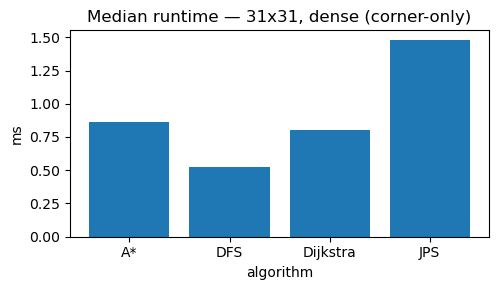

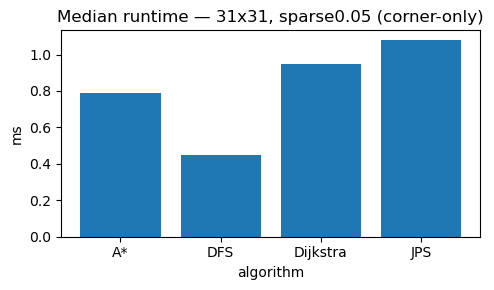

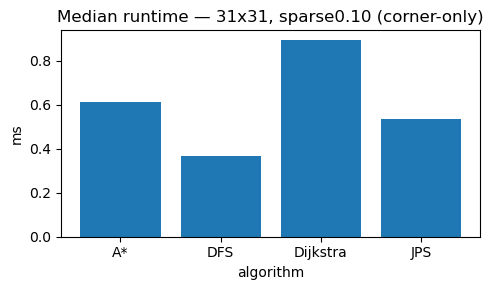

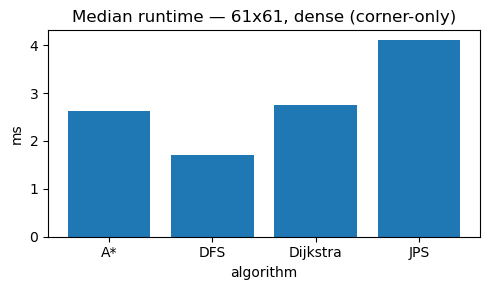

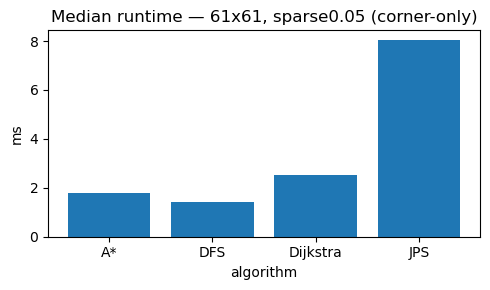

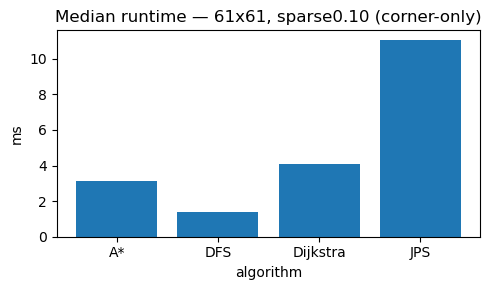

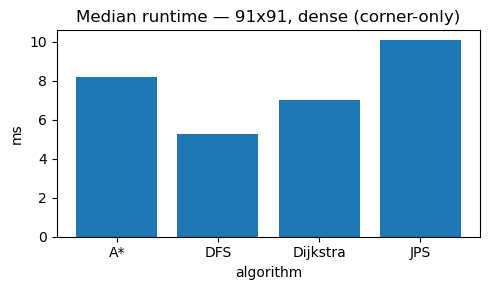

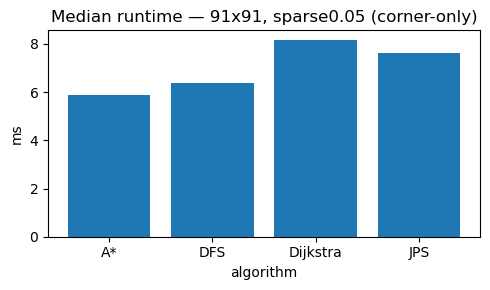

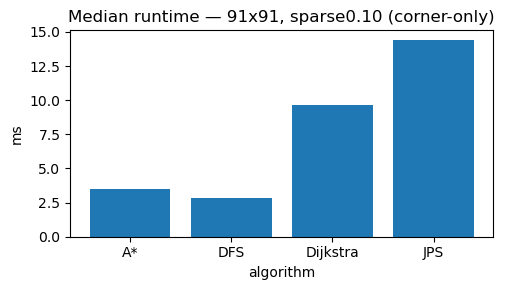

In [7]:

def corner_view(df): return df[df["is_corner"]==1].copy()
def summarize_corner_medians(df):
    corner=corner_view(df)
    return (corner.groupby(["size","map_type","algo"])[["runtime_ms","expanded"]].median().reset_index())
med_table=summarize_corner_medians(df)
print(med_table.sort_values(["size","map_type","runtime_ms"]).head(12))
for (size,mtype),sub in med_table.groupby(["size","map_type"]):
    plt.figure(figsize=(5,3))
    plt.bar(sub["algo"],sub["runtime_ms"])
    plt.title(f"Median runtime — {size}, {mtype} (corner-only)")
    plt.ylabel("ms"); plt.xlabel("algorithm"); plt.tight_layout()
    plt.savefig(os.path.join(ARTIFACTS,f"corner_median_runtime_{size}_{mtype}.png"),dpi=160)
    plt.show()


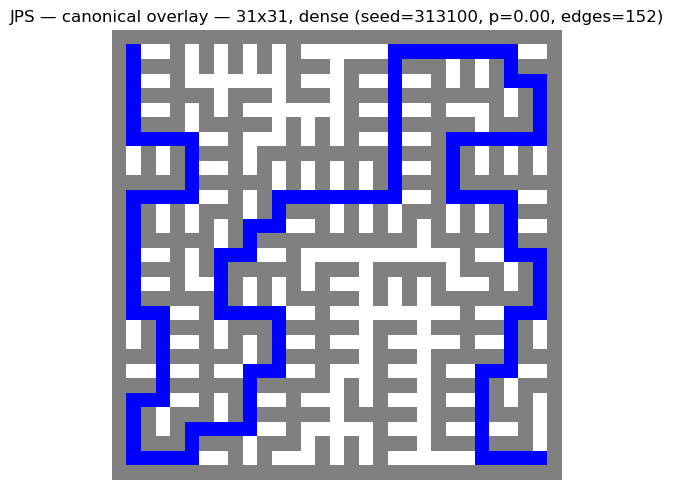

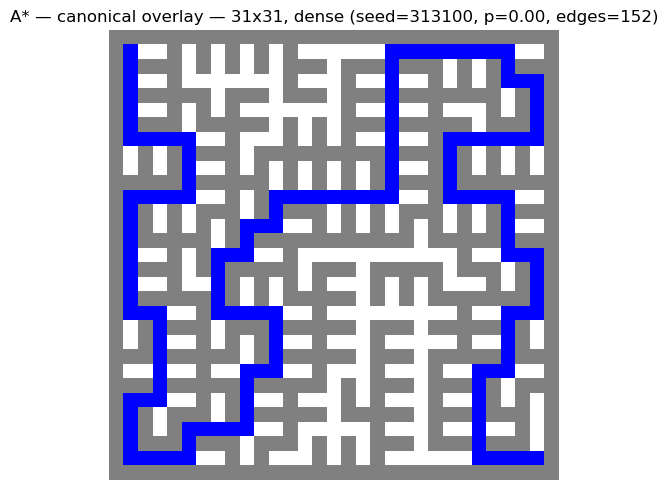

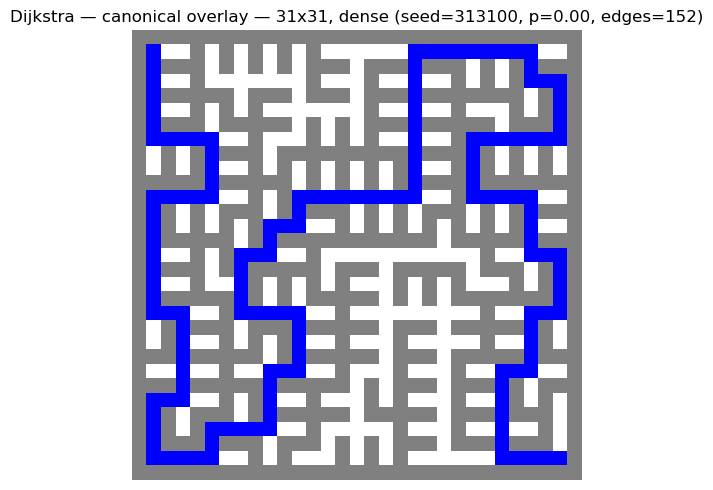

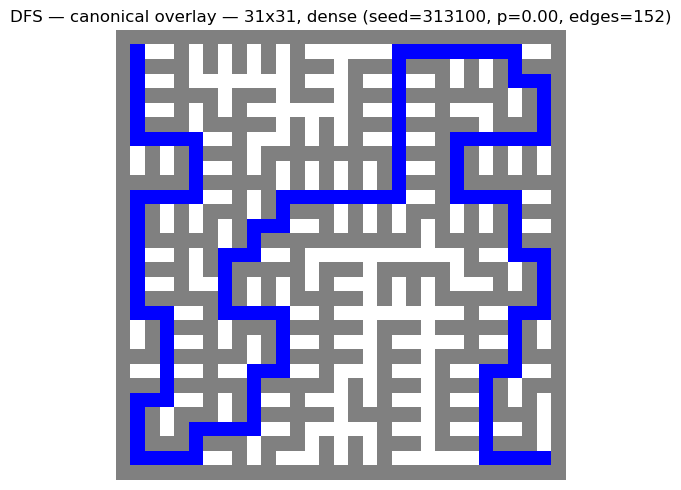

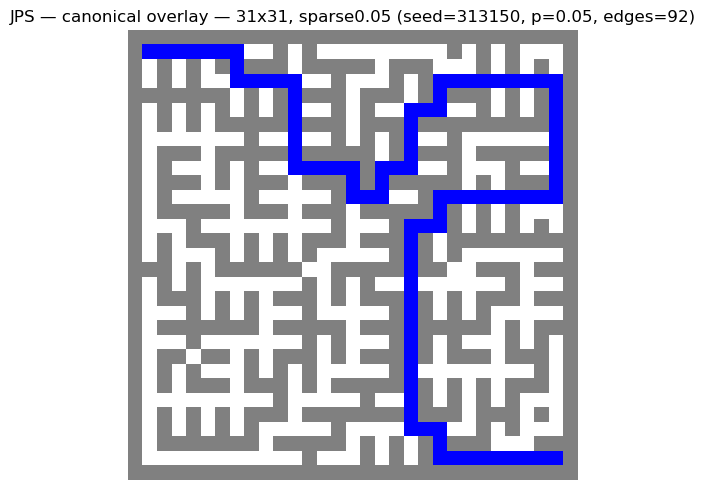

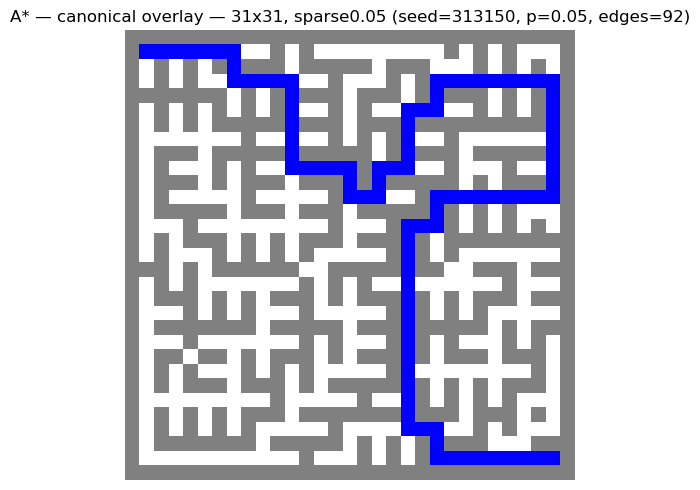

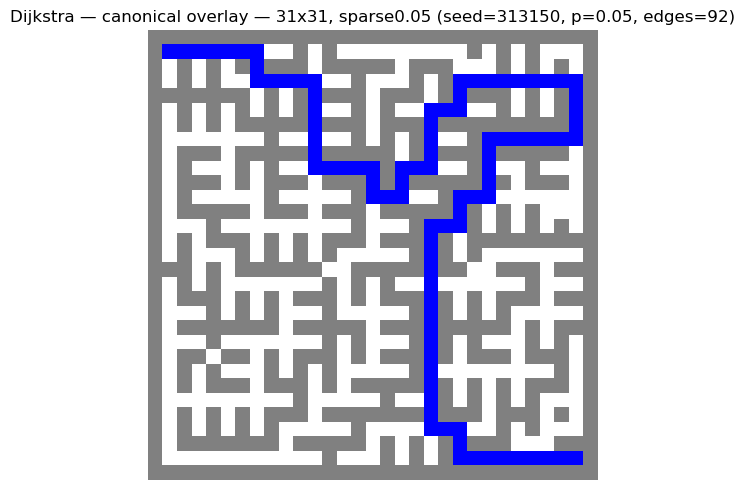

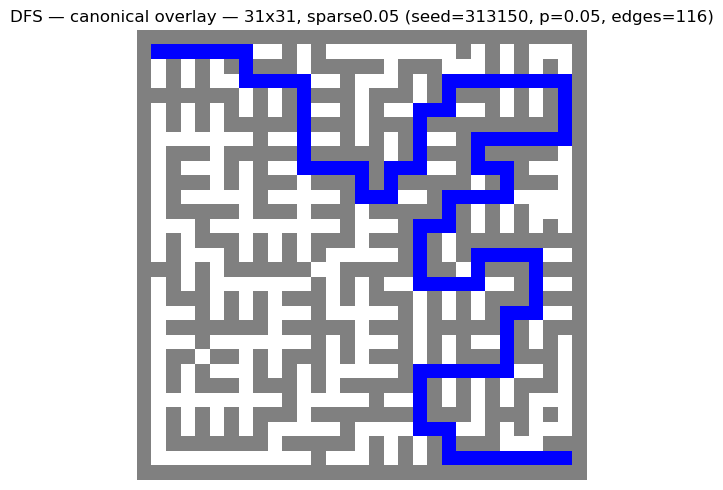

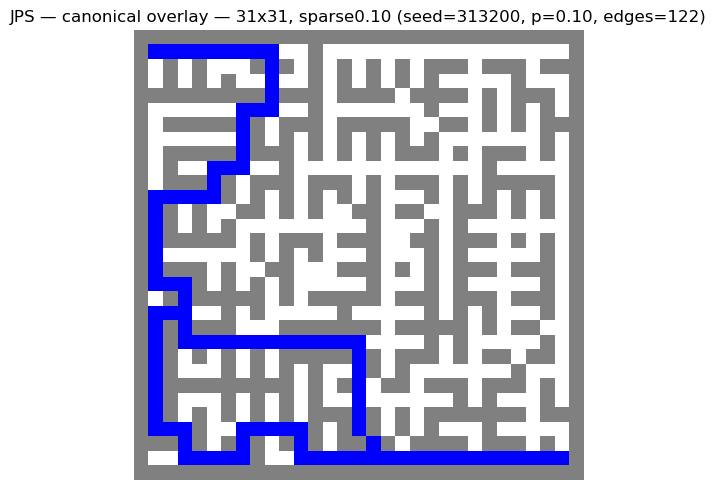

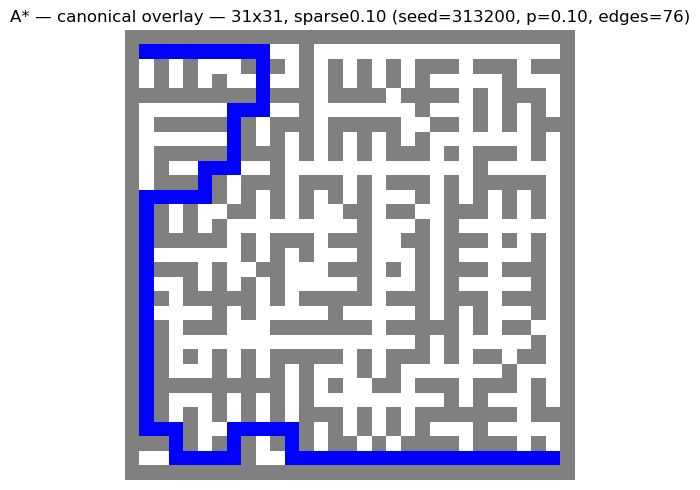

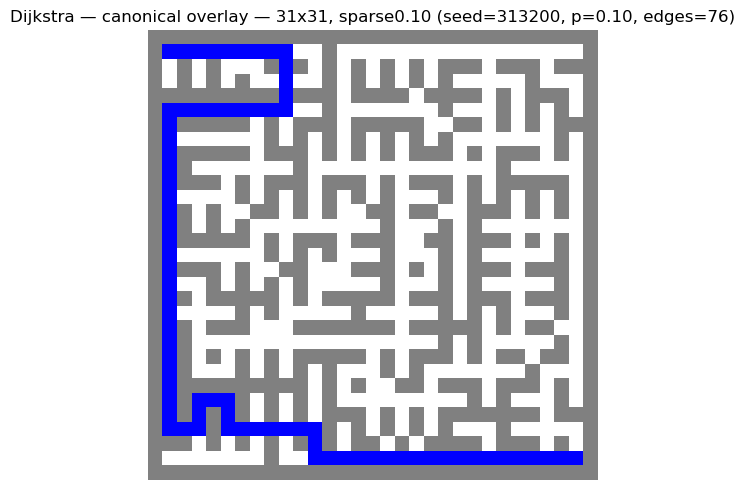

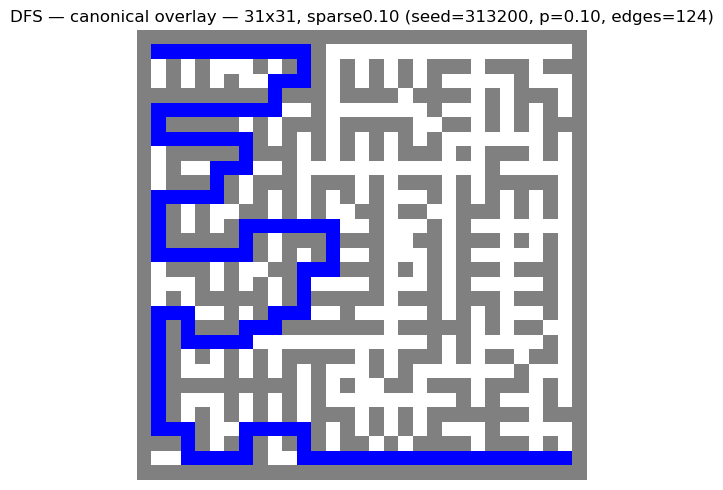

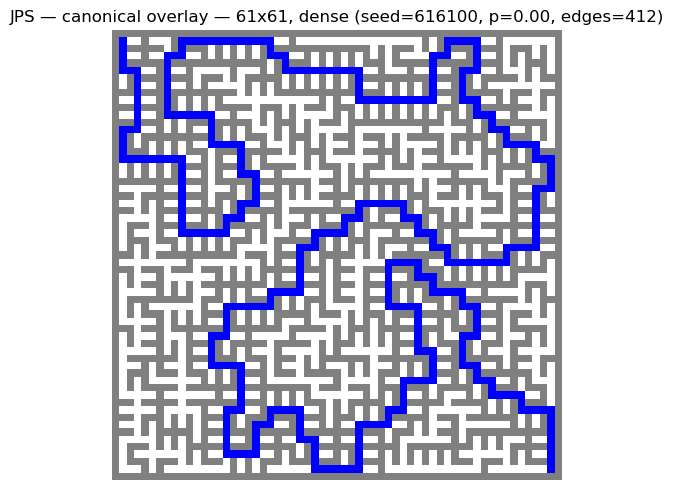

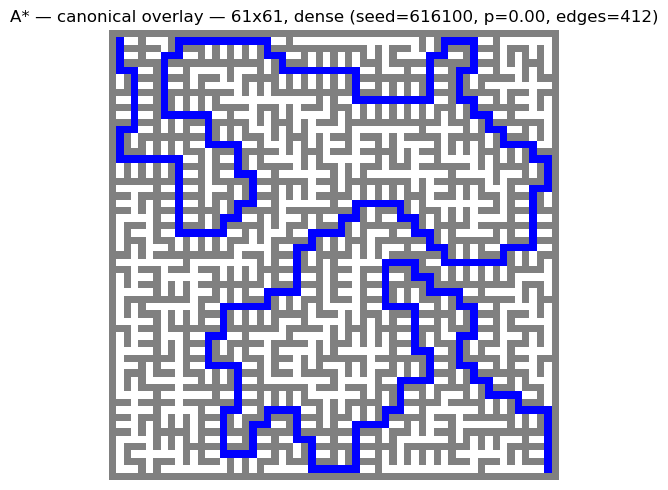

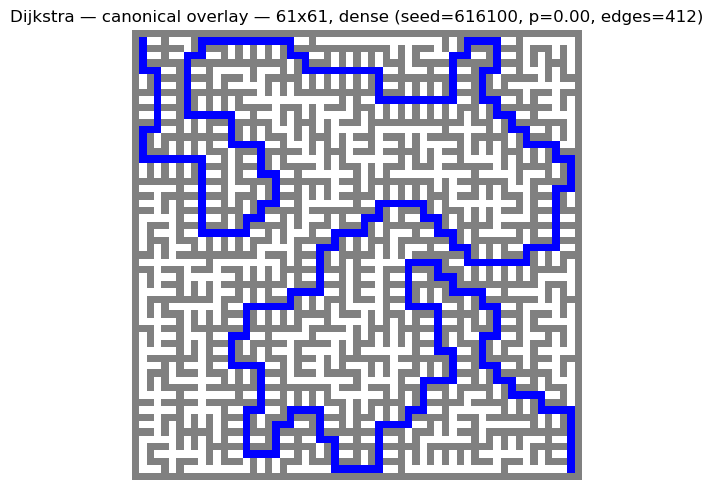

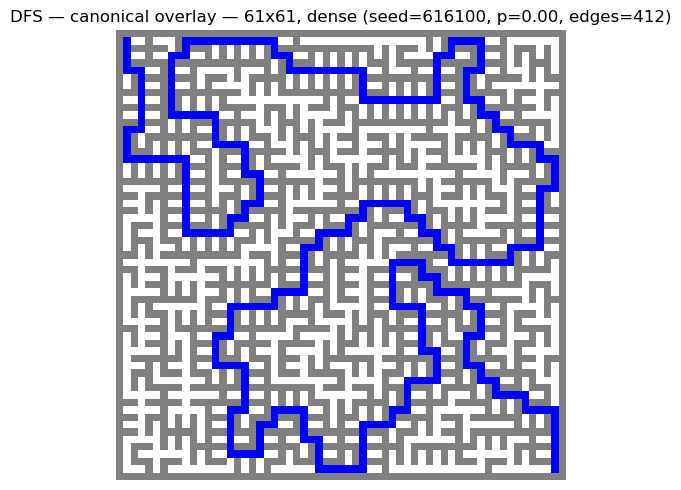

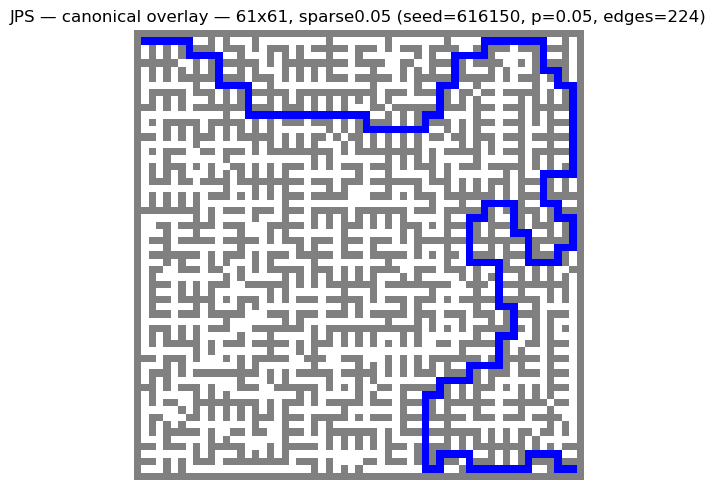

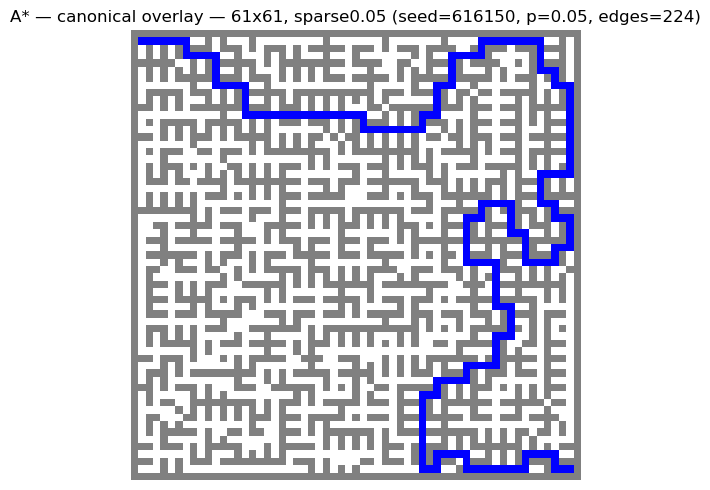

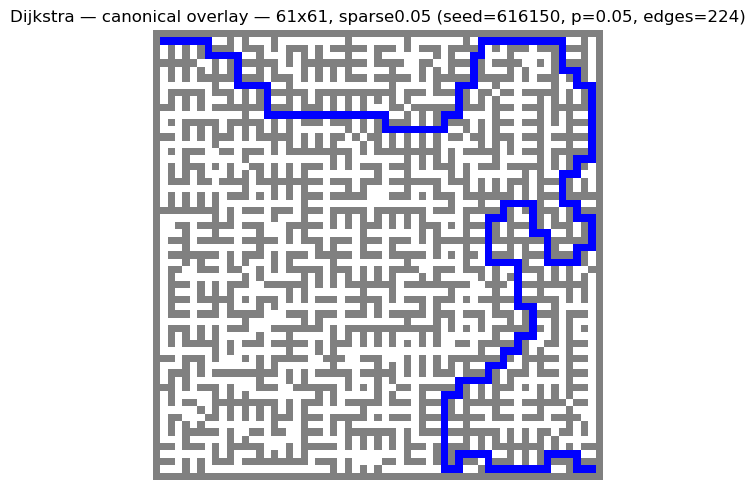

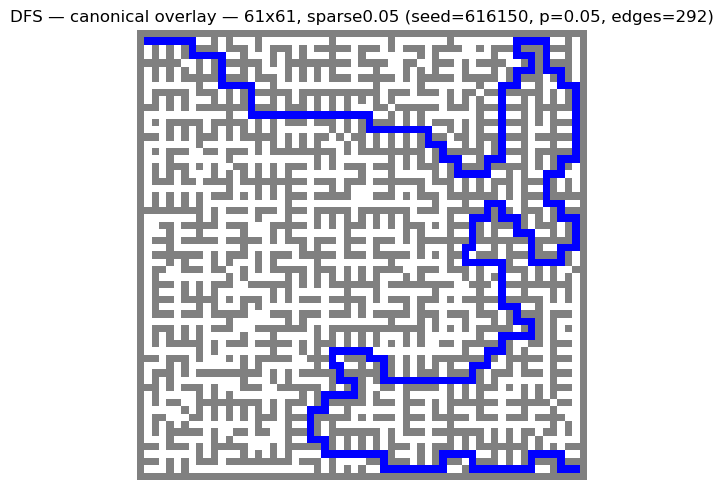

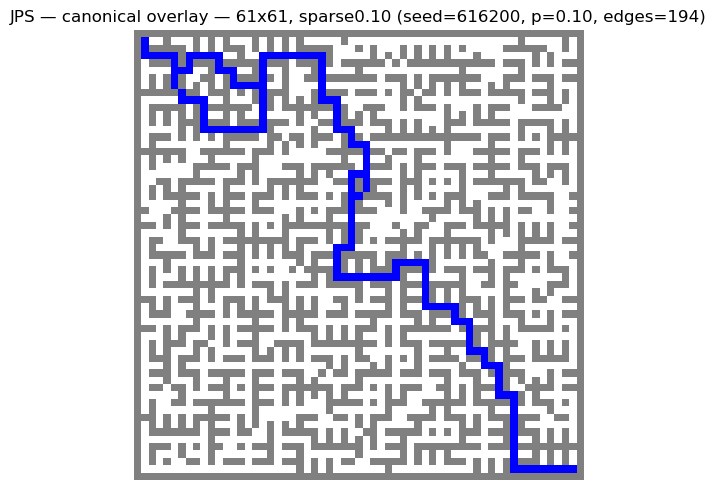

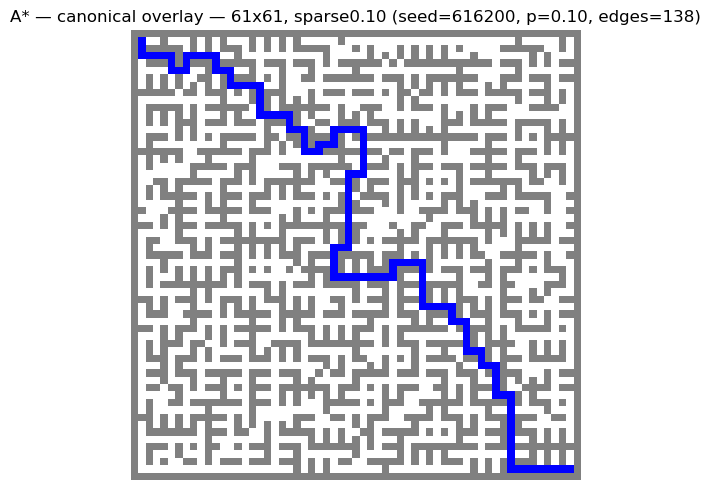

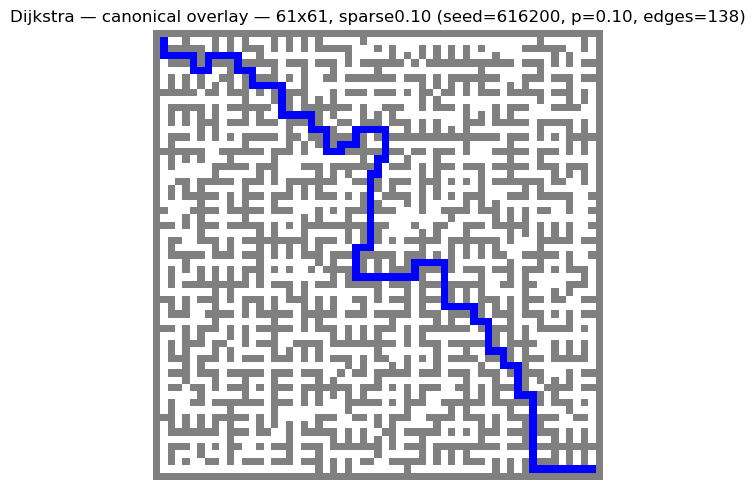

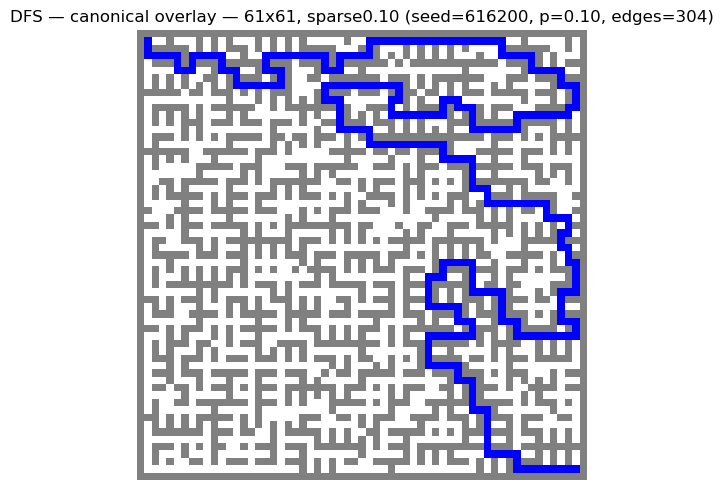

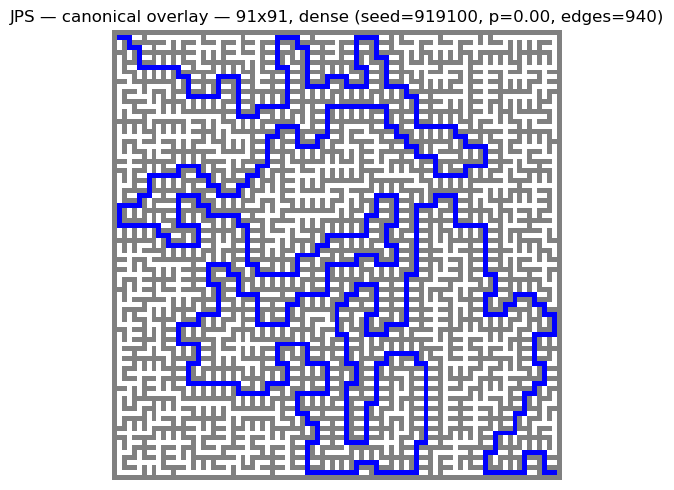

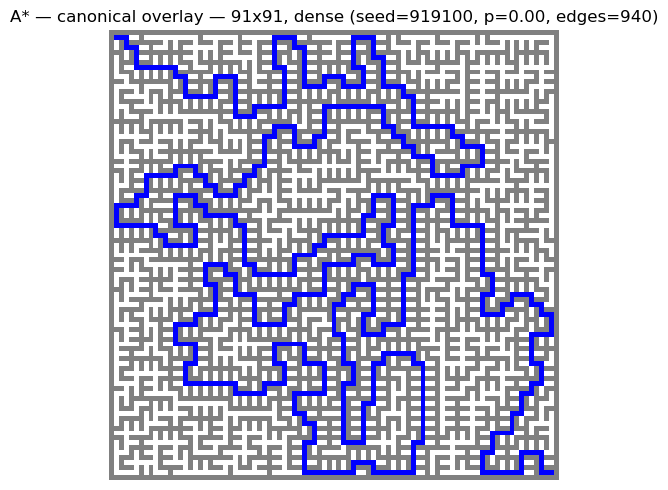

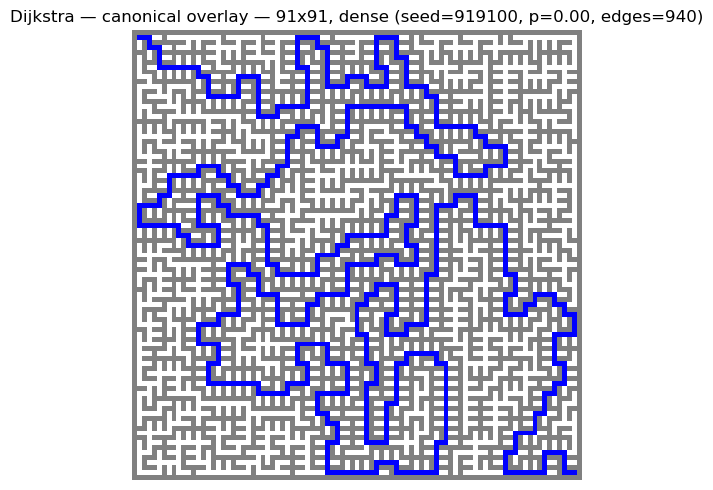

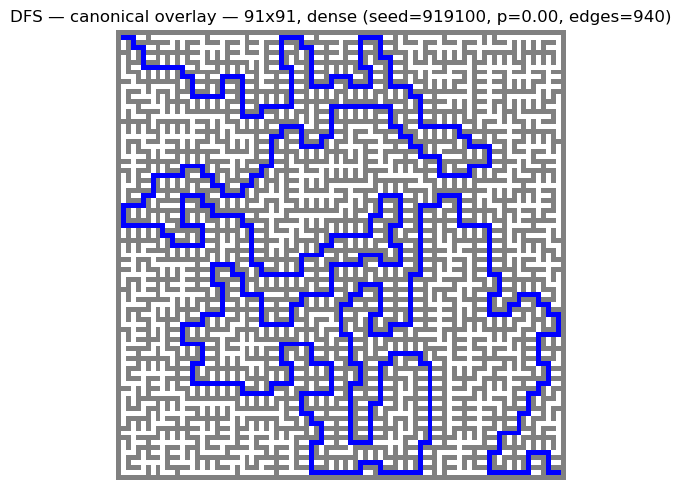

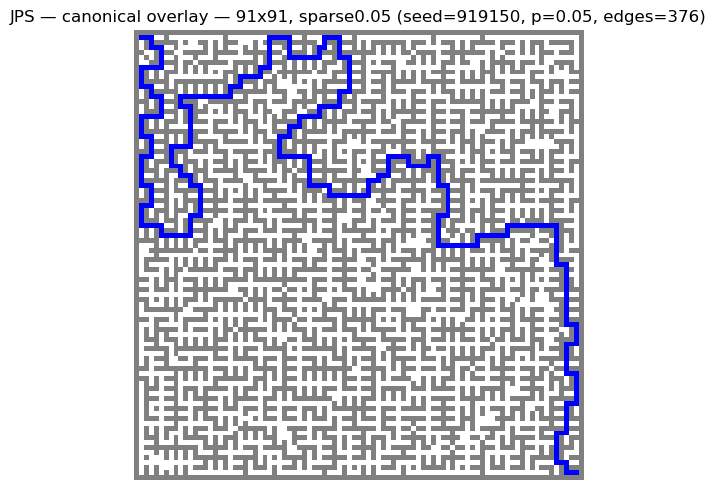

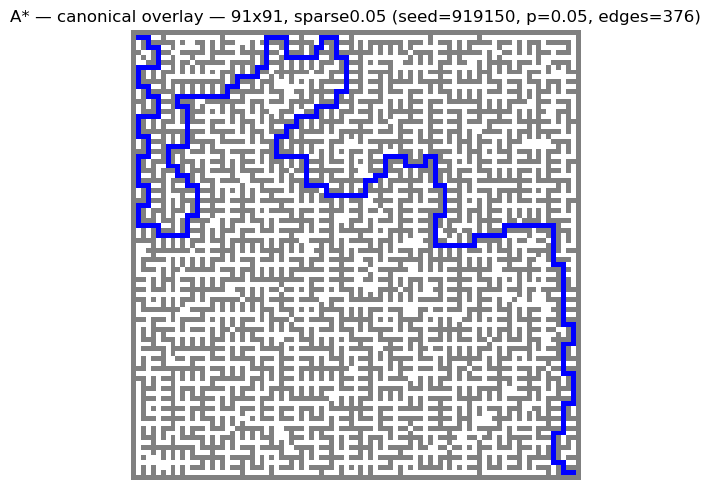

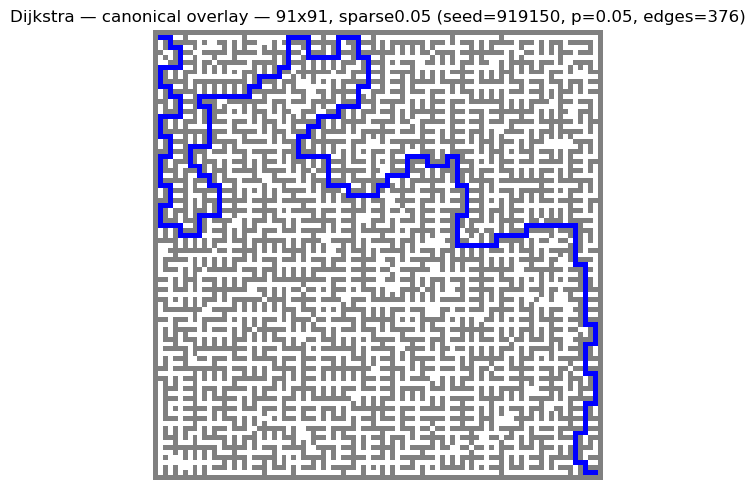

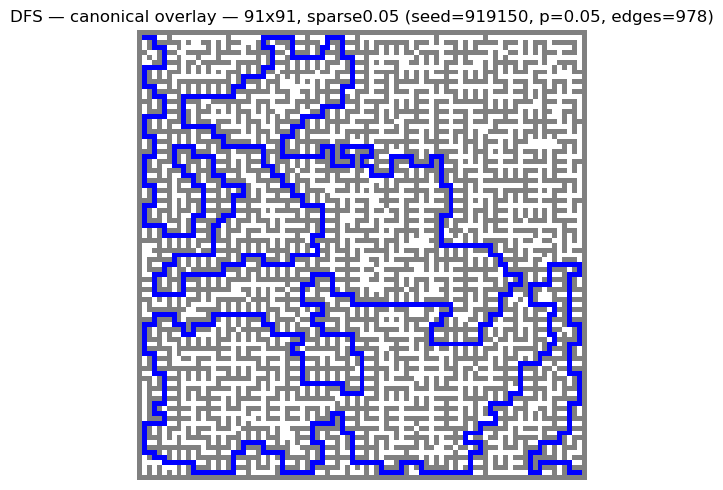

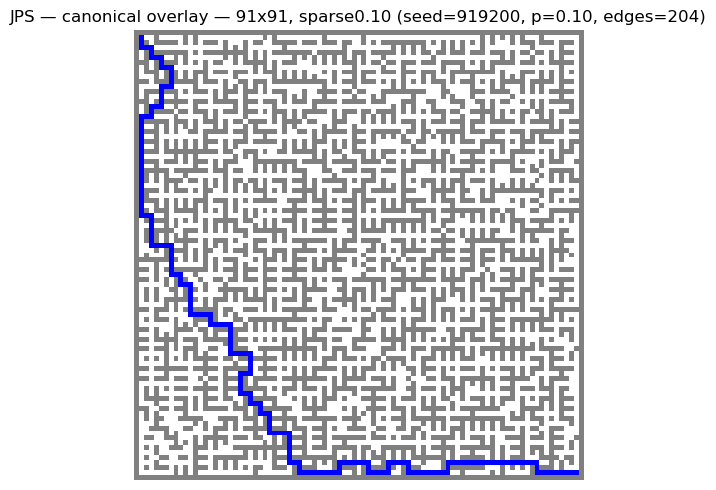

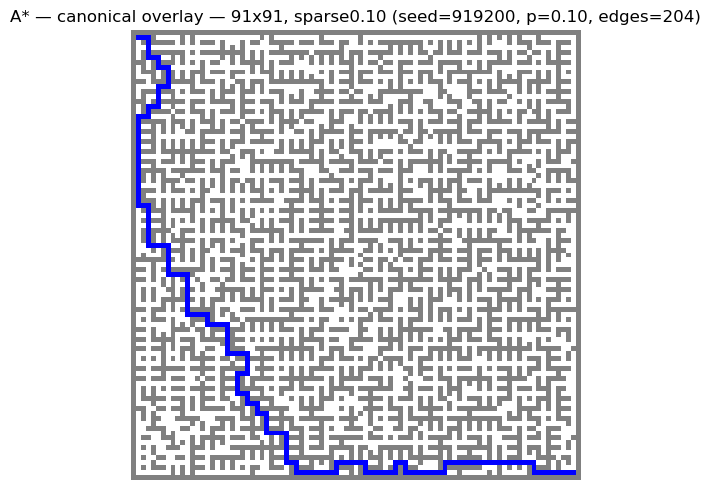

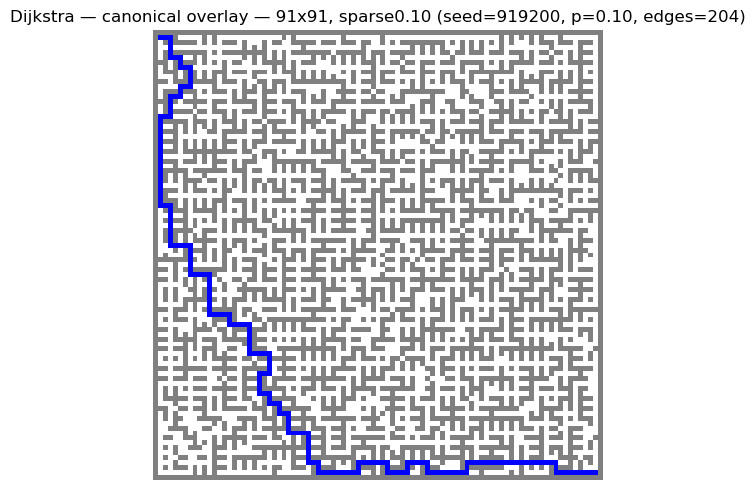

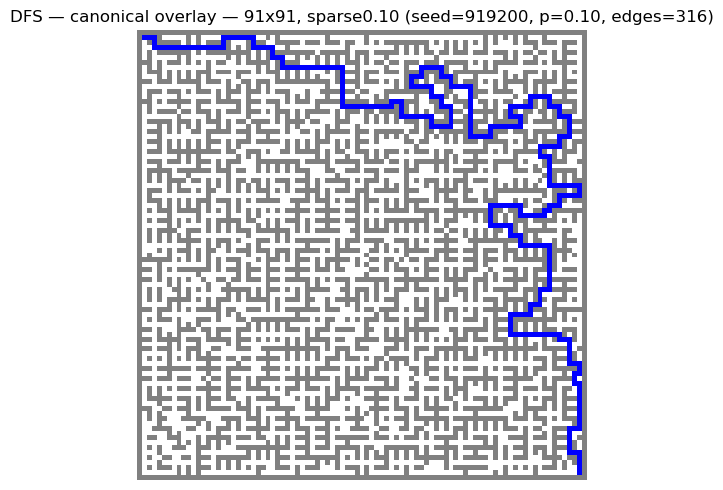

In [8]:

from matplotlib.colors import ListedColormap
def best_run_heatmap(grid,path,title):
    img=grid.copy(); H,W=img.shape
    for y,x in path:
        if 0<=y<H and 0<=x<W: img[y,x]=2
    cmap=ListedColormap(["white","gray","blue"])
    plt.figure(figsize=(5,5)); plt.imshow(img,cmap=cmap,interpolation="none",vmin=0,vmax=2)
    plt.axis("off"); plt.title(title); plt.tight_layout()
    fname=title.replace("*","star").replace(" ","_").replace(",","").replace("—","-")
    plt.savefig(os.path.join(ARTIFACTS,f"overlay_{fname}.png"),dpi=160); plt.show()
def canonical_overlays_corners(df,save=True):
    fn={"A*":astar_metrics,"DFS":dfs_metrics,"Dijkstra":dijkstra_metrics,"JPS":jps_metrics_stitched}
    for size in sorted(df["size"].unique().tolist()):
        H,W=map(int,size.split("x")); start,end=(1,1),(H-2,W-2)
        for mtype in sorted(df["map_type"].unique().tolist()):
            base=df[(df["size"]==size)&(df["map_type"]==mtype)&(df["is_corner"]==1)]
            if base.empty: continue
            r=base.iloc[0]; seed=int(r["seed"]); pval=float(r["p"])
            M=generate_maze_dfs_seeded(W|1,H|1,seed=seed); G=M if pval==0.0 else add_loops(M,p=pval,seed=seed)
            for algo in ["JPS","A*","Dijkstra","DFS"]:
                out=fn[algo](G,start,end); path=out.get("path",[])
                if not path and algo=="JPS": path=_astar_4(G,start,end)
                title=f"{algo} — canonical overlay — {size}, {mtype} (seed={seed}, p={pval:.2f}, edges={len(path)-1})"
                best_run_heatmap(G,path,title)
canonical_overlays_corners(df,save=True)
